In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
import seaborn as sns
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_6_2.parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_7.parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_7_3.parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_7_2 (1).parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_6.parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024 (1).parquet
/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_7_2.parquet
/kaggle/input/nfl-big-data-bowl-2024/players.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv
/kaggle/input/nfl-big-data-bowl-2024/games.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv
/kaggle/input/nfl-big-data-bowl-2024/tackles.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.

In [2]:
plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')

tackles = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')

data_cleaned = pd.read_parquet('/kaggle/input/finalbdbdata-2024-2/Cleaned_Data_2024_1_7_3.parquet')

In [3]:
data_1 = data_cleaned

data_1['onDefense'] = data_1.club == data_1.defensiveTeam

In [4]:
#See if offense, defense, ballcarrier, or football
data_1['role_label'] = "Offense"
data_1.loc[data_1.onDefense, 'role_label'] = "Defense"
data_1.loc[data_1.nflId == data_1.ballCarrierId, 'role_label'] = "Ballcarrier"
data_1.loc[data_1.club == "football", 'role_label'] = "Football"

In [5]:
pos_cols = ['gameId','playId','nflId','displayName','position','frameId','last_frame','club','possessionTeam','X_std','Y_std','o_deg_std','o_rad_std','dir_deg_std','dir_rad_std','speed_x','speed_y','ballc_X','ballc_Y','ballc_o_rad_std','ballc_dir_rad_std','ballc_dx','ballc_dy','ballc_diff_speed_x','ballc_diff_speed_y','dist_ballc','event','role_label']

In [6]:
repulsion_test = data_1.query('club == defensiveTeam')[pos_cols]

In [7]:
#numerator_r is the numerator on the repulsion formula
#it's positive if the force is going left for the ballcarrier
numberator_r_x = -1
numerator_r_y = -1

In [8]:
#changed the distances for x and y to ballc
repulsion_test['repulse_x'] = numberator_r_x*repulsion_test.ballc_diff_speed_x/(repulsion_test.dist_ballc + .01)**2

repulsion_test['repulse_y'] = numerator_r_y*repulsion_test.ballc_diff_speed_y/(repulsion_test.dist_ballc + .01)**2

repulsion_test['repulse_total'] = np.sqrt((repulsion_test.ballc_diff_speed_x ** 2) + (repulsion_test.ballc_diff_speed_y **2))/(repulsion_test.dist_ballc+.01)**2

repulsion_test['indiv_F_theta'] = np.arctan(repulsion_test.repulse_y / repulsion_test.repulse_x)

repulsion_test['repulse_y_x_ratio'] = repulsion_test.repulse_y / repulsion_test.repulse_x

In [9]:
force_data_merged = data_1.merge(repulsion_test[['gameId', 'playId', 'frameId', 'nflId', 'repulse_x', 'repulse_y', 'repulse_total','indiv_F_theta','repulse_y_x_ratio']], 
                                 how='left',  # Left join to keep all rows from data_1
                                 on=['gameId', 'playId', 'frameId', 'nflId'])

In [10]:
force_data_merged['ballc_f_x_total'] = force_data_merged.groupby(['gameId','playId','frameId'])['repulse_x'].transform(np.sum)

force_data_merged['ballc_f_y_total'] = force_data_merged.groupby(['gameId','playId','frameId'])['repulse_y'].transform(np.sum)

force_data_merged['ballc_total_F_theta'] = np.arctan2(force_data_merged.ballc_f_y_total, force_data_merged.ballc_f_x_total)

force_data_merged['ballc_total_F_ratio'] = force_data_merged.ballc_f_y_total/ force_data_merged.ballc_f_x_total

In [13]:
def animate_plays_vector_updated_2(tracking_data, fps=5):
    fig, ax = plt.subplots()
    play_frame_count = tracking_data.frameId.unique().max()

    # Extract unique player_ids and roles
    unique_players = tracking_data['nflId'].unique()
    roles = tracking_data['role_label'].unique()

    # Set up plot for each role
    role_colors = {'Offense': 'blue', 'Defense': 'red', 'Ballcarrier': 'green', 'Football': 'brown'}
    role_dots = {}
    
    for role in roles:
        role_frame_data = tracking_data[(tracking_data['role_label'] == role) & (tracking_data['frameId'] == 1)]
        role_dots[role], = ax.plot(role_frame_data['X_std'], role_frame_data['Y_std'],
                                   'o', color=role_colors[role], label=role)

    ax.axvline(x=20, color='black', linestyle='-', linewidth=2)  # Left end zone
    ax.axvline(x=100, color='black', linestyle='-', linewidth=2)  # Right end zone

    # Add green backdrop
    ax.fill_betweenx(y=[0, 160 / 3], x1=20, x2=100, color='green', alpha=0.3)

    ax.legend(loc='upper right')

    def update(frame):
        ax.clear()
        
                # Re-plot the green backdrop
        field_backdrop = plt.Rectangle((0, 0), 120, 160 / 3, fc='green', alpha=0.3)
        ax.add_patch(field_backdrop)

        for role in roles:
            role_frame_data = tracking_data[(tracking_data['frameId'] == frame) & (tracking_data['role_label'] == role)]
            role_dots[role] = ax.plot(role_frame_data['X_std'], role_frame_data['Y_std'],
                                      'o', color=role_colors[role], label=role)[0]

            if role == 'Defense':
                for i, player in role_frame_data.iterrows():
                    magnitude = player['repulse_total']  # Adjust the scaling factor as needed
                    angle = player['indiv_F_theta']  # Adjust the angle calculation
                    positive_angle = np.arctan(abs(player['repulse_y_x_ratio']))

                    dx = magnitude * np.cos(positive_angle) * np.sign(player['repulse_x'])
                    dy = magnitude * np.sin(positive_angle) * np.sign(player['repulse_y'])

                    ax.arrow(player['X_std'], player['Y_std'], dx, dy,
                             head_width=0.2, head_length=0.4, fc='black', ec='black', width=0.05, zorder=5)

            elif role == 'Ballcarrier':
                ballcarrier_data = role_frame_data.iloc[0]  # Assuming there's only one ball carrier in a frame
                ballcarrier_magnitude = 10  # Adjust the constant size for the ball carrier arrows
                ballcarrier_angle = ballcarrier_data['ballc_total_F_theta']

                ballcarrier_dx = ballcarrier_magnitude * np.cos(ballcarrier_angle) * -1
                ballcarrier_dy = ballcarrier_magnitude * np.sin(ballcarrier_angle) * -1

                # First arrow (same as before)
                ax.arrow(ballcarrier_data['X_std'], ballcarrier_data['Y_std'], ballcarrier_dx, ballcarrier_dy,
                         head_width=2, head_length=1, fc='orange', ec='orange', width=0.05, zorder=5,
                         length_includes_head=True, head_starts_at_zero=False, alpha=0.8)

                # Second arrow based on 'ballc_dir_rad_std' with arrowhead
                ballcarrier_dir_angle = np.degrees(ballcarrier_data['ballc_a_dir'])  # Convert radians to degrees
                ballcarrier_dir_dx = ballcarrier_magnitude * np.cos(np.radians(ballcarrier_dir_angle))
                ballcarrier_dir_dy = ballcarrier_magnitude * np.sin(np.radians(ballcarrier_dir_angle))

                ax.arrow(ballcarrier_data['X_std'], ballcarrier_data['Y_std'], ballcarrier_dir_dx, ballcarrier_dir_dy,
                         head_width=2, head_length=1, fc='green', ec='green', width=0.05, zorder=5,
                         length_includes_head=True, head_starts_at_zero=False, alpha=0.8)

        ax.axvline(x=20, color='black', linestyle='-', linewidth=2)  # Left end zone
        ax.axvline(x=100, color='black', linestyle='-', linewidth=2)  # Right end zone

        ax.set_xlim(0, 120)
        ax.set_ylim(0, 160 / 3)
        ax.set_title(f'Frame {frame}')

    interval = 1000 / fps  # Calculate the interval in milliseconds
    animation = FuncAnimation(fig, update, frames=range(1, play_frame_count + 1), repeat=False, interval=interval)

    # Display the animation using the HTML class
    html_str = animation.to_jshtml()
    display(HTML(html_str))

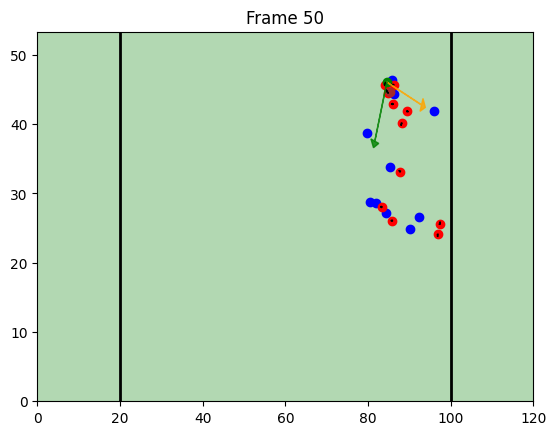

In [15]:
animate_plays_vector_updated_2(force_data_merged.query('gameId == 2022090800 & playId == 1102'))

In [ ]:
force_data_merged.to_parquet('Force_Data_cleaned.parquet')